# **Taylor diagrams for spatial patterns**

In [1]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *
from taylorDiagram import TaylorDiagram, taylor_scores
import xesmf as xe

## **Regrid model data to target grid**

In [2]:
era5 = xr.open_dataset("ann_pr_era5_1980_2010.nc").tp

In [58]:
regridded_cmip6 = []
varnm = "tasmin"
fl = glob.glob(varnm+"_spatial/*.nc")
for fnm in fl:
    ds = xr.open_dataset(fnm)[varnm]
    if "height" in ds.coords: ds = ds.reset_coords("height", drop = True)
    regrid = xe.Regridder(ds, era5, method = "conservative", unmapped_to_nan = True)
    regridded_cmip6.append(regrid(ds).expand_dims(run = ["_".join(fnm.split("_")[3:-1])]).rename(varnm))
regridded_cmip6 = xr.concat(regridded_cmip6, "run")
regridded_cmip6 = regridded_cmip6.isel(lon = slice(5,-1), lat = slice(5,-5)) # trim to avoid edge effects
regridded_cmip6.to_netcdf("ann_"+varnm+"_models-regridded-to-era5.nc")

## **Taylor diagrams**

### **Precipitation**

In [74]:
regridded_cmip6 = xr.open_dataset("ann_pr_models-regridded-to-era5.nc").pr.sortby("run") / 365
era5 = xr.open_dataset("ann_pr_era5_1980_2010.nc").tp

In [75]:
corrs, sds = taylor_scores(regridded_cmip6, era5)
ref_sd = era5.std().values

In [76]:
max_sd = max(np.ceil(max(sds)) / ref_sd, 1.1)
min_corr = min(corrs)

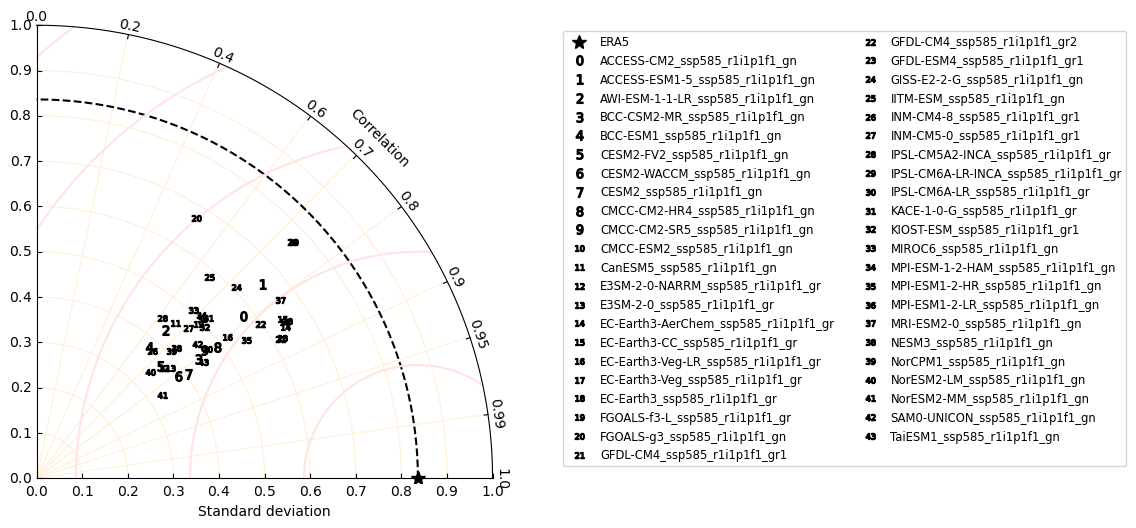

In [77]:
fig = plt.figure(figsize = (6,6), dpi= 100, facecolor='w', edgecolor='k')
td = TaylorDiagram(ref_sd, fig = fig, label = "ERA5", srange = (0, max_sd), extend = False)

td.add_contours(colors = "mistyrose") # lines of equal RMSE
td.add_grid(color = "papayawhip")  # lines of equal correlation & SD

for i in range(len(corrs)):
    td.add_sample(sds[i], corrs[i], marker = "$"+str(i)+"$", ms = 7, ls = '', mfc = "tab:blue", mec = "black", label = regridded_cmip6.run.values[i])
    
fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (1,0.5), ncols = 2)

### **Maximum temperatures**

In [82]:
regridded_cmip6 = xr.open_dataset("ann_tasmax_models-regridded-to-era5.nc").tasmax.sortby("run")
era5 = xr.open_dataset("ann_tmax_era5_1980_2010.nc").tmax

In [83]:
corrs, sds = taylor_scores(regridded_cmip6, era5)
ref_sd = era5.std().values

In [84]:
max_sd = max(np.ceil(max(sds)) / ref_sd, 1.1)
min_corr = min(corrs)

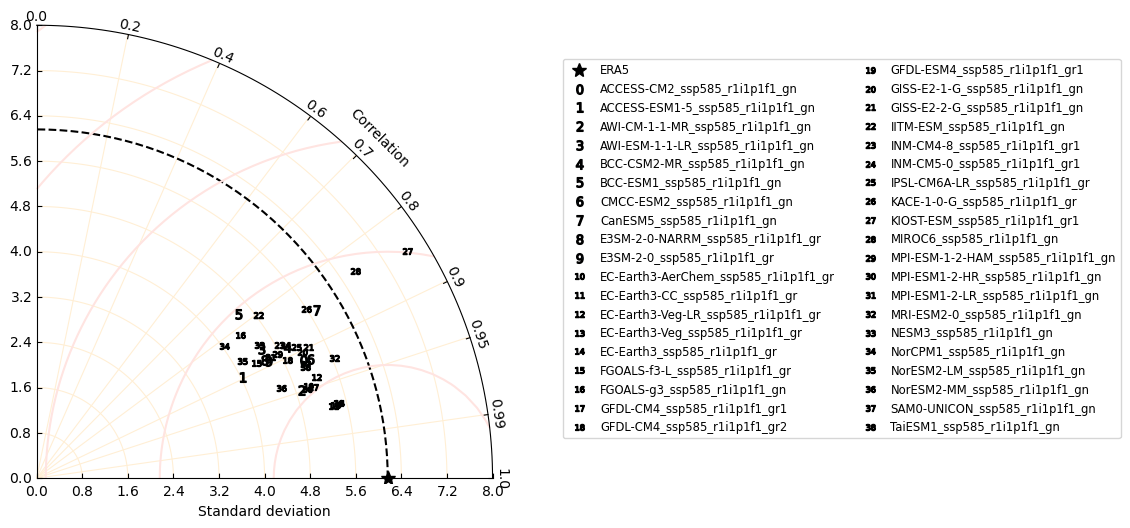

In [85]:
fig = plt.figure(figsize = (6,6), dpi= 100, facecolor='w', edgecolor='k')
td = TaylorDiagram(ref_sd, fig = fig, label = "ERA5", srange = (0, max_sd), extend = False)

td.add_contours(colors = "mistyrose") # lines of equal RMSE
td.add_grid(color = "papayawhip")  # lines of equal correlation & SD

for i in range(len(corrs)):
    td.add_sample(sds[i], corrs[i], marker = "$"+str(i)+"$", ms = 7, ls = '', mfc = "tab:blue", mec = "black", label = regridded_cmip6.run.values[i])
    
fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (1,0.5), ncols = 2)

### **Minimum temperatures**

In [86]:
regridded_cmip6 = xr.open_dataset("ann_tasmin_models-regridded-to-era5.nc").tasmin.sortby("run")
era5 = xr.open_dataset("ann_tmin_era5_1980_2010.nc").tmin

In [87]:
corrs, sds = taylor_scores(regridded_cmip6, era5)
ref_sd = era5.std().values

In [88]:
max_sd = max(np.ceil(max(sds)) / ref_sd, 1.1)
min_corr = min(corrs)

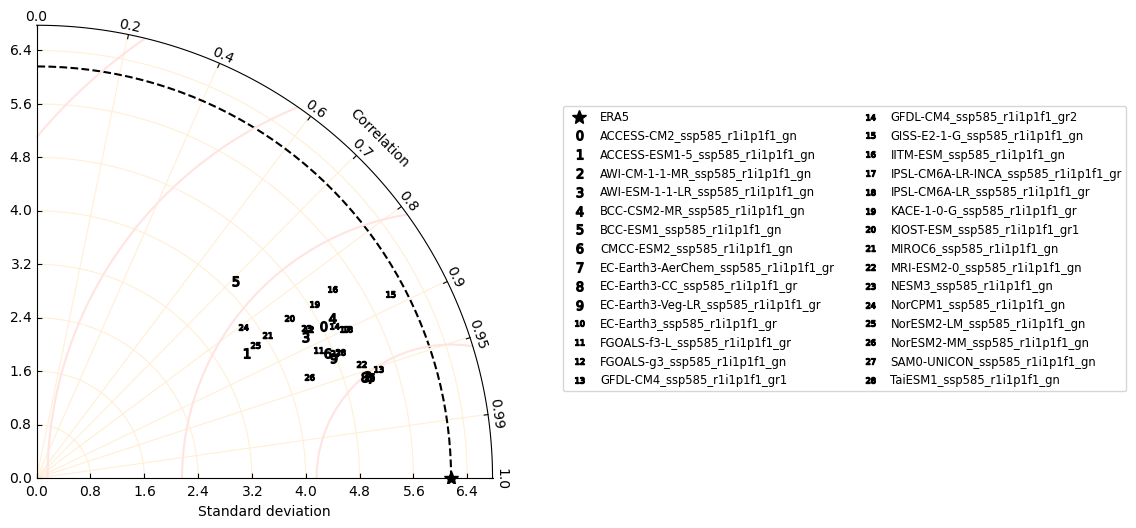

In [89]:
fig = plt.figure(figsize = (6,6), dpi= 100, facecolor='w', edgecolor='k')
td = TaylorDiagram(ref_sd, fig = fig, label = "ERA5", srange = (0, max_sd), extend = False)

td.add_contours(colors = "mistyrose") # lines of equal RMSE
td.add_grid(color = "papayawhip")  # lines of equal correlation & SD

for i in range(len(corrs)):
    td.add_sample(sds[i], corrs[i], marker = "$"+str(i)+"$", ms = 7, ls = '', mfc = "tab:blue", mec = "black", label = regridded_cmip6.run.values[i])
    
fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (1,0.5), ncols = 2)

## **precip + tmax + tmin**

In [54]:
# load CMIP6 spatial patterns
pr_cmip6 = xr.open_dataset("ann_pr_models-regridded-to-era5.nc").pr.sortby("run") / 365
tmax_cmip6 = xr.open_dataset("ann_tasmax_models-regridded-to-era5.nc").tasmax.sortby("run")
tmin_cmip6 = xr.open_dataset("ann_tasmin_models-regridded-to-era5.nc").tasmin.sortby("run")

# filter to retain only those models with historical & SSP runs
cmip6_models = sorted(['EC-Earth3-Veg-LR', 'IPSL-CM6A-LR', 'KACE-1-0-G', 'EC-Earth3-CC', 'CMCC-ESM2', 'NorESM2-LM', 'EC-Earth3', 'FGOALS-g3', 'MRI-ESM2-0', 'ACCESS-CM2',
                       'MIROC6', 'GFDL-CM4', 'NorESM2-MM', 'TaiESM1', 'ACCESS-ESM1-5'])
pr_cmip6, tmax_cmip6, tmin_cmip6 = [da.sel(run = [r.split("_")[0] in cmip6_models for r in da.run.values]) for da in [pr_cmip6, tmax_cmip6, tmin_cmip6]]

# load ERA5 spatial patterns
pr_era5, tmax_era5, tmin_era5 = [xr.open_dataset("ann_"+varnm+"_era5_1980_2010.nc")[re.sub("pr", "tp", varnm)] for varnm in ["pr", "tmax", "tmin"]]

cmip6_models = pr_cmip6.run.values

In [55]:
# calculate scores for Taylor diagrams
pr_scores = taylor_scores(pr_cmip6, pr_era5)
tmax_scores = taylor_scores(tmax_cmip6, tmax_era5)
tmin_scores = taylor_scores(tmin_cmip6, tmin_era5)

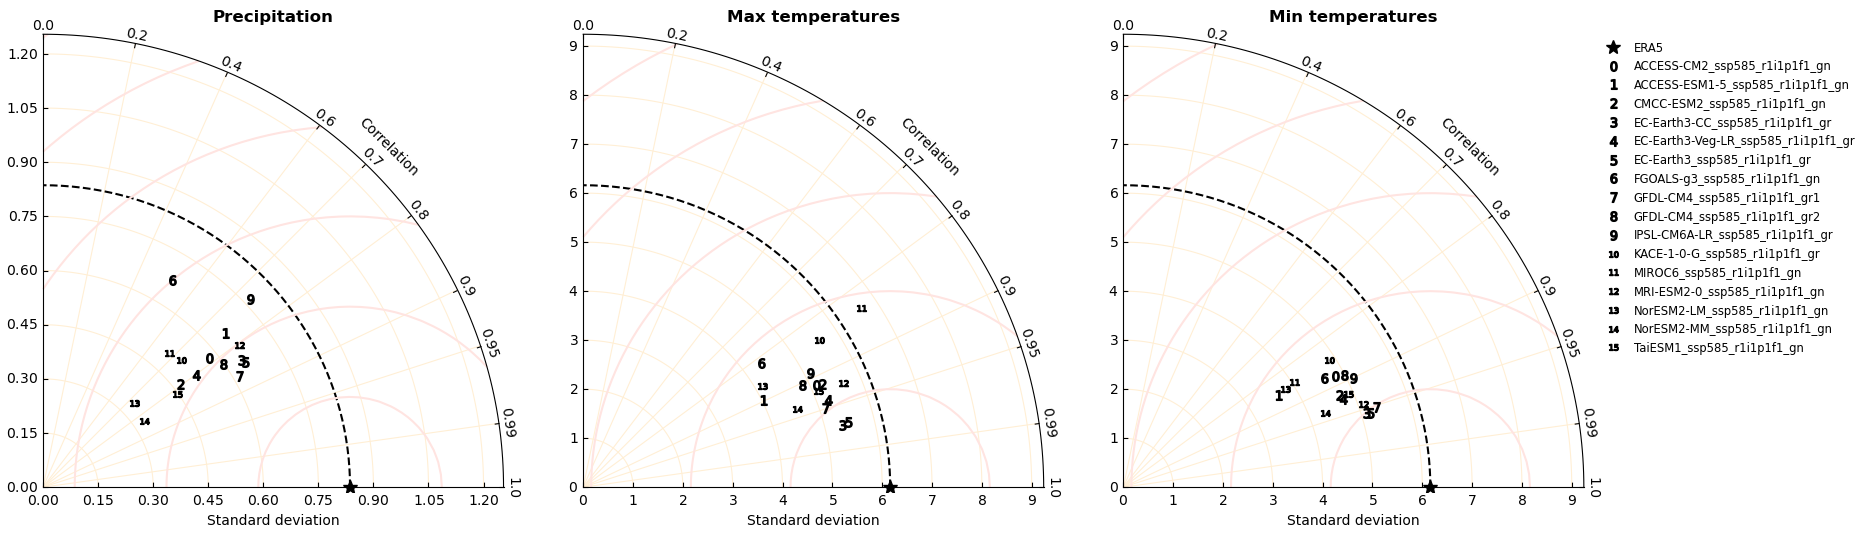

In [70]:
# plot
fig, axs = plt.subplots(ncols = 3, figsize = (20,6), dpi= 100, facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace = 0.15)

for ax in axs: 
    ax.set_aspect('equal')
    ax.set_axis_off()
    
for i in range(3):
    
    # extract SDs & correlations for current variable
    corrs, sds, ref_sd = [pr_scores, tmax_scores, tmin_scores][i]
    
    # create the Taylor Diagram axes
    td = TaylorDiagram(ref_sd, fig = fig, rect=130+i+1, label="ERA5")
    td.add_contours(colors = "mistyrose")                                   # lines of equal RMSE
    td.add_grid(color = "papayawhip")                                       # lines of equal correlation & SD
    axs[i].set_title(["Precipitation", "Max temperatures", "Min temperatures"][i], fontweight = "bold")
    
    # add points
    for j in range(len(cmip6_models)):
        td.add_sample(sds[j], corrs[j], marker = "$"+str(j)+"$", ms = 7, ls = '', mfc = "tab:blue", mec = "black", label = cmip6_models[j])
        
fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center', bbox_to_anchor = (0.97,0.6), ncols = 1, edgecolor = "w")

plt.savefig("taylor-diagram_cmip6.png")